# Pixel induced current
In this notebook we load a track dataset and we calculate the current induced on the pixels placed at the anode.

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import consts, quenching, drifting, detsim, pixels_from_track, fee
from larndsim import indeces as i

import importlib
importlib.reload(detsim)
importlib.reload(drifting)
importlib.reload(quenching)
importlib.reload(consts)
importlib.reload(pixels_from_track)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pickle
import numpy as np
import numba as nb
import pandas as pd

from numba import cuda
from math import ceil, sqrt, pi, exp, erf
from time import time

INFO:quenching:QUENCHING MODULE PARAMETERS
INFO:quenching:TPC parameters
Electric field magnitude: 0.5 kV/cm
Liquid argon density: 1.38 g/cm^3
Box alpha parameter: 0.847
Box beta parameter: 0.2061 cm/MeV
Birks A_b parameter: 0.8
Birks k_b parameter: 0.0486 g/cm^2/MeV

INFO:drifting:DRIFTING MODULE PARAMETERS
INFO:drifting:Drift velocity: 0.153812 us/cm
Longitudinal diffusion coefficient: 4e-09 cm^2 / us,
Transverse diffusion coefficient: 8.8e-09 cm
Electron lifetime: 10000 us
TPC borders: (0 cm, 100 cm) x, (-150 cm, 150 cm) y, (0 cm, 100 cm) z

INFO:detsim:DETSIM MODULE PARAMETERS
INFO:detsim:TPC parameters
Drift velocity: 0.153812 us/cm
Time sampling: 0.1 us
Time padding: 10 us
TPC borders: (0 cm, 100 cm) x, (-150 cm, 150 cm) y, (0 cm, 100 cm) z
Sampled points per slice: 50
INFO:detsim:Pixel parameters
Pixel size: (0.4 x 0.4) cm^2

INFO:pixels_from_track:PIXEL_FROM_TRACK MODULE PARAMETERS
INFO:pixels_from_track:TPC parameters
TPC borders: (0 cm, 100 cm) x, (-150 cm, 150 cm) y, (0 cm, 

Here we load the dataset with the tracks and we store the column cols corresponding to the each variable.

In [3]:
tracks_np = pickle.load(open('argoncube_tracks.p', 'rb'))
d_tracks_np = cuda.to_device(tracks_np)

In [7]:
dir(i)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dE',
 'dEdx',
 'long_diff',
 'n_electrons',
 't',
 't_end',
 't_start',
 'tran_diff',
 'x',
 'x_end',
 'x_start',
 'y',
 'y_end',
 'y_start',
 'z',
 'z_end',
 'z_start']

In [5]:
threadsperblock = 256
blockspergrid = ceil(tracks_np.shape[0] / threadsperblock)

quenching.quench[threadsperblock,blockspergrid](d_tracks_np, consts.box)
drifting.drift[threadsperblock,blockspergrid](d_tracks_np)

In [5]:
tracks_np = d_tracks_np.copy_to_host()

In [6]:
%load_ext wurlitzer

## Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [51]:
nn = np.logspace(0,2,1,dtype=np.int32)
times_gpu = []
times_gpu_memory = []

for n in nn:
    selected_tracks = d_tracks_np[150:200]
    # Here we find the pixels involved 
    active_pixels = np.zeros(shape=(selected_tracks.shape[0], 15, 2))
    neighboring_pixels = np.full((selected_tracks.shape[0], 50, 2), -1)
    d_neighboring_pixels = cuda.to_device(neighboring_pixels)
    d_active_pixels = cuda.to_device(active_pixels)
    n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))
    threadsperblock = 128
    blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
    pixels_from_track.get_pixels[blockspergrid,threadsperblock](selected_tracks, 
                                                                d_active_pixels, 
                                                                d_neighboring_pixels, 
                                                                n_pixels_list)

    # Here we calculate the track start times and the longest signal time
    max_length = np.array([0])
    track_starts = np.empty(selected_tracks.shape[0])
    d_track_starts = cuda.to_device(track_starts)
    blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
    detsim.time_intervals[blockspergrid,threadsperblock](d_track_starts, max_length, selected_tracks)
    
    start = time()
    # Here we calculate the induced current signals
    signals = np.zeros((selected_tracks.shape[0], 
                        neighboring_pixels.shape[1], 
                        max_length[0]), dtype=np.float32)
    threadsperblock = (4,4,4)
    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    d_signals = cuda.to_device(signals)

    start_nomemory = time()
    detsim.tracks_current[blockspergrid,threadsperblock](d_signals, 
                                                         d_neighboring_pixels, 
                                                         selected_tracks)
    end_nomemory = time()
    end = time()
    times_gpu.append(end_nomemory-start_nomemory)
    times_gpu_memory.append(end-start)

In [52]:
# neighboring_pixels = d_neighboring_pixels.copy_to_host()

In [53]:
tot_pix = np.vstack(d_neighboring_pixels)
tot_pix = tot_pix[(tot_pix[:,0]>-1) & (tot_pix[:,1]>-1)]
unique_pix = []

for pix in tot_pix:
    pixl = [pix[0],pix[1]]
    if pixl not in unique_pix:
        unique_pix.append(pixl)

In [54]:
unique_pix = np.array(unique_pix)

In [55]:
pixel_index_map = np.full((selected_tracks.shape[0], 50), -1)

for itr in range(d_neighboring_pixels.shape[0]):
    for ipix in range(d_neighboring_pixels.shape[1]):
        pID = d_neighboring_pixels[itr][ipix]
        if pID[0] >= 0 and pID[1] >= 0:
            index = np.where((unique_pix[:,0] == pID[0]) & (unique_pix[:,1] == pID[1]))[0][0]
            pixel_index_map[itr,ipix] = index
            
d_pixel_index_map = cuda.to_device(pixel_index_map)

In [56]:
pixels_signals = np.zeros((len(unique_pix),len(consts.time_ticks)))
d_pixels_signals = cuda.to_device(pixels_signals)

In [57]:
threadsperblock = (4,4,4)
blockspergrid_x = ceil(d_signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(d_signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(d_signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
detsim.sum_pixel_signals[blockspergrid,threadsperblock](d_pixels_signals, 
                                                        d_signals, 
                                                        d_track_starts, 
                                                        d_pixel_index_map)

In [58]:
nn_cpu = np.logspace(0,3,10,dtype=np.int32)
times_cpu = [0.01742410659790039,
             0.050868988037109375,
             0.059677839279174805,
             0.12185907363891602,
             0.23131489753723145,
             0.48302698135375977,
             1.0946669578552246,
             2.4459469318389893,
             5.015509843826294,
             11.755344152450562]

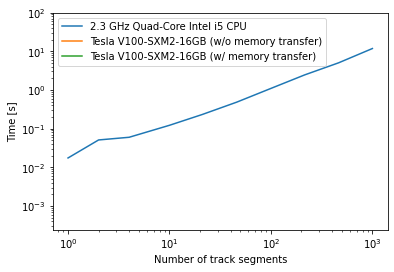

In [59]:
plt.plot(nn_cpu,times_cpu,label='2.3 GHz Quad-Core Intel i5 CPU')
plt.plot(nn, times_gpu, label='%s (w/o memory transfer)' 
                              % cuda.cudadrv.driver.Device(0).name.decode())
plt.plot(nn, times_gpu_memory, label='%s (w/ memory transfer)'
                                     % cuda.cudadrv.driver.Device(0).name.decode())
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=1e2)
plt.xlabel("Number of track segments")
plt.ylabel("Time [s]")
_ = plt.legend()
plt.savefig("times.pdf")

In [60]:
currents = np.sum(d_pixels_signals,axis=1)

In [61]:
adc_list = np.zeros((d_pixels_signals.shape[0], 3))
adc_ticks_list = np.zeros((d_pixels_signals.shape[0], 3))

In [62]:
threadsperblock = 128
blockspergrid = ceil(d_pixels_signals.shape[0] / threadsperblock)
fee.get_adc_values[blockspergrid,threadsperblock](d_pixels_signals, consts.time_ticks, adc_list, adc_ticks_list)

More ADC values than possible,  2
More ADC values than possible,  2


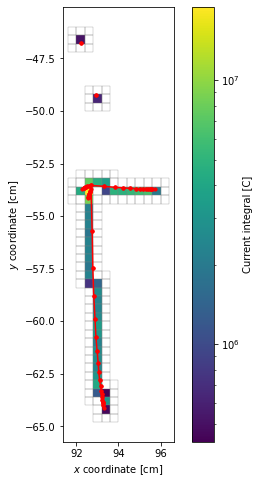

In [63]:
norm = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1,figsize=(8,8))
for ip,c in enumerate(currents):
    p = unique_pix[ip]
    x_rect = p[0]*consts.pixel_size[0]+consts.tpc_borders[0][0]
    y_rect = p[1]*consts.pixel_size[1]+consts.tpc_borders[1][0]

    rect = plt.Rectangle((x_rect, y_rect),
                         consts.pixel_size[0], consts.pixel_size[1],
                         linewidth=0.3,
                         edgecolor='grey', 
                         facecolor=m.to_rgba(c), label='Pixel')
    ax.add_patch(rect)
    
for it,t in enumerate(selected_tracks):

    ax.plot((t[i.x_start], t[i.x_end]), 
            (t[i.y_start], t[i.y_end]),
            c='r',
            zorder=10)
    ax.scatter((t[i.x_start], t[i.x_end]), 
               (t[i.y_start], t[i.y_end]),
               c='r',
               s=10,
               zorder=10)

ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")
ax.set_aspect("equal")
# ax.set_xlim(92,94)
# ax.set_ylim(top=-52)
_ = plt.colorbar(m,fraction=0.049, pad=0.04, label='Current integral [C]')
fig.savefig("charge.pdf")

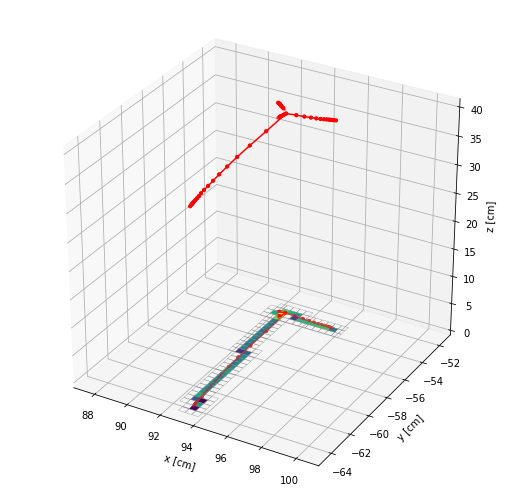

In [64]:
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111,projection='3d')
for ip,c in enumerate(currents):
    p = unique_pix[ip]
    x_rect = p[0]*consts.pixel_size[0]+consts.tpc_borders[0][0]
    y_rect = p[1]*consts.pixel_size[1]+consts.tpc_borders[1][0]
    if y_rect > -51:
        continue
    rect = plt.Rectangle((x_rect, y_rect),
                         consts.pixel_size[0], consts.pixel_size[1],
                         linewidth=0.3,
                         edgecolor='grey', 
                         facecolor=m.to_rgba(currents[ip]), label='Pixel')
    ax.add_patch(rect)
    art3d.pathpatch_2d_to_3d(rect, z=consts.tpc_borders[2][0], zdir="z")

for t in selected_tracks:
    if t[i.y_start] > -51:
        continue
    ax.plot((t[i.x_start], t[i.x_end]), 
            (t[i.y_start], t[i.y_end]),
            (t[i.z_start], t[i.z_end]),
            c='r')
    ax.plot((t[i.x_start], t[i.x_end]), 
            (t[i.y_start], t[i.y_end]),
            (0,0),
            c='r', alpha=0.5, zorder=9999)
    ax.scatter((t[i.x_start], t[i.x_end]), 
               (t[i.y_start], t[i.y_end]),
               (t[i.z_start], t[i.z_end]),
               c='r',
               s=10)
    ax.scatter((t[i.x_start], t[i.x_end]), 
               (t[i.y_start], t[i.y_end]),
               (0,0),
               c='r', alpha=0.5, zorder=9999,
               s=10)
ax.set_zlim(bottom=consts.tpc_borders[2][0])
ax.set_xlim(87,101)
ax.set_ylim(-65,-51)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")
fig.savefig("3d.pdf")

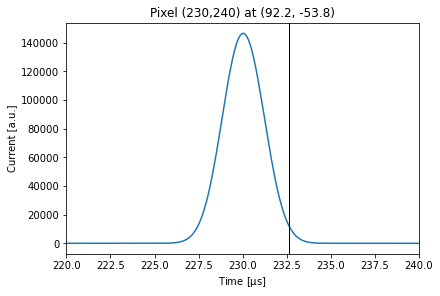

In [65]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
pixelID = detsim.pixel_from_coordinates(92.54, -53.95, consts.n_pixels)
pixelID = 230,240
index = np.where((unique_pix[:,0] == pixelID[0]) & (unique_pix[:,1] == pixelID[1]))[0][0]
ax.plot(consts.time_ticks,d_pixels_signals[index])
ax.set_xlim(220,240)   
ax.set_title("Pixel (%i,%i) at (%g, %g)" % (pixelID[0], pixelID[1], 
                                            pixelID[0]*consts.pixel_size[0] + consts.pixel_size[0]/2 + consts.tpc_borders[0][0], 
                                            pixelID[1]*consts.pixel_size[1] + consts.pixel_size[1]/2 + consts.tpc_borders[1][0]))
ax.set_xlabel("Time [$\mathrm{\mu}$s]")
ax.axvline(x=adc_ticks_list[1][0],lw=1,c='black')
ax.axvline(x=adc_ticks_list[1][1],lw=1,c='black')


# ax.set_ylim(top=20)
ax.set_ylabel("Current [a.u.]")
fig.savefig("current.pdf")